In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
class MSHEContrastEnhancement:
    def __init__(self, image, num_intervals=2):
        self.image = image
        self.num_intervals = num_intervals

    def linear_stretching(self, img):
        """
        Step 1: Linear Stretching
        ! Paper Reference: Eq. (14)
        """
        
        img_min, img_max = img.min(), img.max()
        stretched = ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)  # Adjusting to [0, 255]
        return stretched

    def calculate_cp(self, img):
        """
        Calculate the central point (Cp) using cumulative frequency sum
        ! Paper Reference: Eq. (17)
        """
       
        hist, bins = np.histogram(img, bins=256, range=(0, 255))
        total_pixels = hist.sum()
        Fs = 0  # Initialize cumulative frequency sum
        for i, freq in enumerate(hist):
            Fs += freq
            if Fs >= 0.25 * total_pixels:  # Assuming lower quantile (25%)
                return bins[i]  # Return pixel value corresponding to Cp
        return bins[-1]  # Default to max value if not found

    def divide_histogram(self, img):
        """
        Step 2: Interval Division Threshold Selection
        ! Paper Reference: Eq. (18), (19), and handling of odd/even cases
        """
        
        Cp = self.calculate_cp(img)  # Calculate central point using Eq. (17)
        print(Cp)
        thresholds = []

        if self.num_intervals == 2:
            # Special Case: N_i = 2
            thresholds = [0, Cp, 255]
        elif self.num_intervals % 2 == 0:
            # Even intervals: Include Cp as a threshold
            num_intervals_half = self.num_intervals // 2
            # Generate thresholds to the left of Cp
            thresholds += [Cp - i for i in range(0, int(Cp), int(Cp / num_intervals_half))]
            # Generate thresholds to the right of Cp
            thresholds += [Cp + i for i in range(0, 256 - int(Cp), int((256 - Cp) / num_intervals_half))]
            thresholds = sorted(set([0] + thresholds + [255]))
        else:
            # Odd intervals: Exclude Cp as a threshold
            num_intervals_half = (self.num_intervals - 1) // 2
            # Generate thresholds to the left of Cp
            thresholds += [Cp - i for i in range(0, int(Cp), int(Cp / num_intervals_half))]
            # Generate thresholds to the right of Cp
            thresholds += [Cp + i for i in range(0, 256 - int(Cp), int((256 - Cp) / num_intervals_half))]
            thresholds = sorted(set([0] + thresholds + [255]))
            # Ensure Cp is only used for calculation and not as a threshold
            thresholds.remove(Cp)

        subhistograms = [(img >= thresholds[i]) & (img <= thresholds[i + 1]) for i in range(len(thresholds) - 1)]
        return subhistograms, thresholds

    def equalize_subhistogram(self, img, mask, min_val, max_val):
        """
        Step 3: Subhistogram Equalization using Eq. (29)
        ! Paper Reference: Eq. (29)
        """
        sub_img = img[mask]
        if len(sub_img) > 1:
            hist, bins = np.histogram(sub_img, bins=256, range=(min_val, max_val))
            cdf = hist.cumsum()
            cdf = cdf / cdf[-1]  # Normalized CDF
            
            # ! Apply Eq. (29)
            d_a = min_val
            d_a1 = max_val
            transformed_values = d_a + 1 + ((d_a1 - d_a - 1) * cdf)
            
            # Map the original pixel values to transformed values
            img[mask] = np.interp(sub_img, bins[:-1], transformed_values).astype(np.uint8)
        return img

    def enhance_contrast(self):
        """
        Apply MSHE Contrast Enhancement
        """
        stretched_img = self.linear_stretching(self.image)
        subhistograms, thresholds = self.divide_histogram(stretched_img)

        for i, mask in enumerate(subhistograms):
            stretched_img = self.equalize_subhistogram(stretched_img, mask, thresholds[i], thresholds[i + 1])

        return stretched_img


In [3]:
"""
    Make sure to have the following directory structure:
    turbid-image-enhancement
    ├── data
    |   ├── dataset
    |   |   ├── train
    |   |   |   ├── all the directories containing images
    
    ! Make sure to have this, or else you need to change the code accordingly
"""

class UnderwaterImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(subdir, file)
            for subdir, _, files in os.walk(root_dir)
            for file in files if file.endswith(('png', 'jpg', 'jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [4]:
def show_images(original, enhanced):
    """
    Display original and enhanced images side by side.
    """
    fig, axs = plt.subplots(2, len(original), figsize=(12, 6))
    for i in range(len(original)):
        axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axs[0, i].axis('off')
        axs[0, i].set_title("Original")

        axs[1, i].imshow(enhanced[i], cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title("Enhanced")

    plt.show()


In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = UnderwaterImageDataset(root_dir='/home/anakin513/Semester-7/Semester Project/Dataset/EUVP_Dataset/Paired-20241008T083418Z-001/Paired/underwater_dark/trainA', transform=transform) # ! Change the path accordingly, if required
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)


47.8125
57.7734375
32.87109375
21.9140625
53.7890625


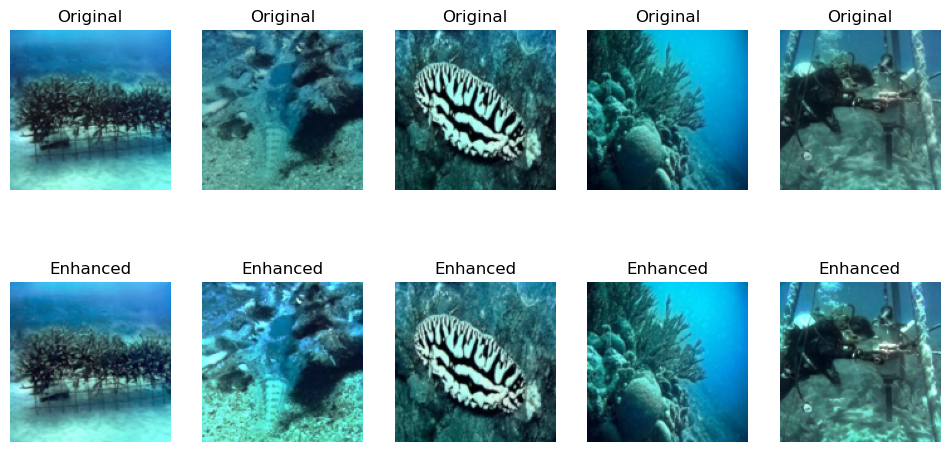

In [11]:
# data_iter = iter(dataloader)
# images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=5)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)

47.8125
57.7734375
32.87109375
21.9140625
53.7890625


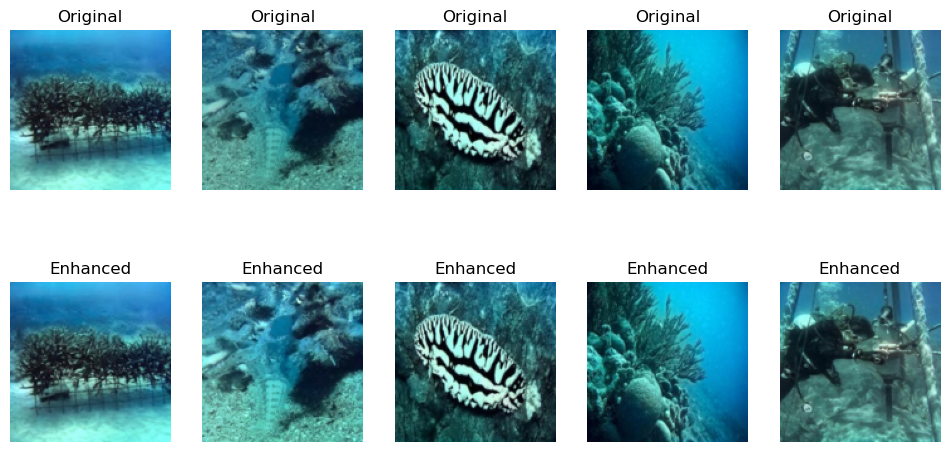

In [ ]:
# data_iter = iter(dataloader)
# images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=10)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)

122.51953125
26.89453125
45.8203125
23.90625
38.84765625


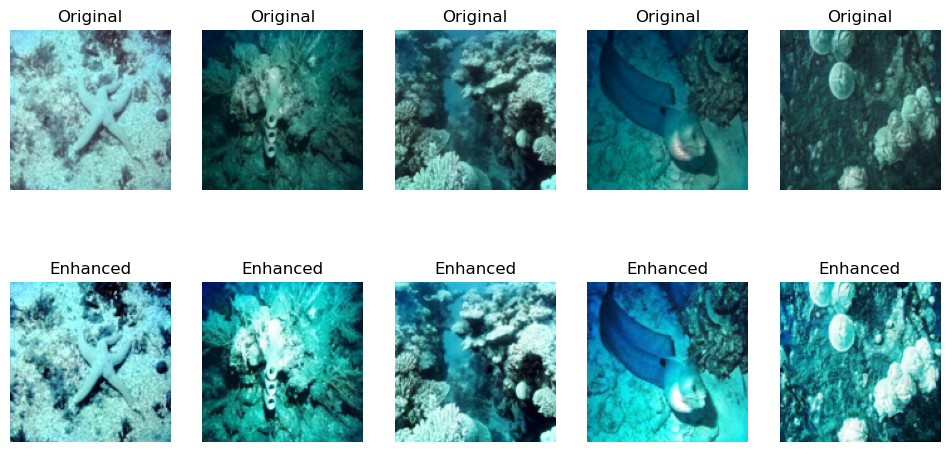

In [16]:
data_iter = iter(dataloader)
images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=2)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)

122.51953125
26.89453125
45.8203125
23.90625
38.84765625


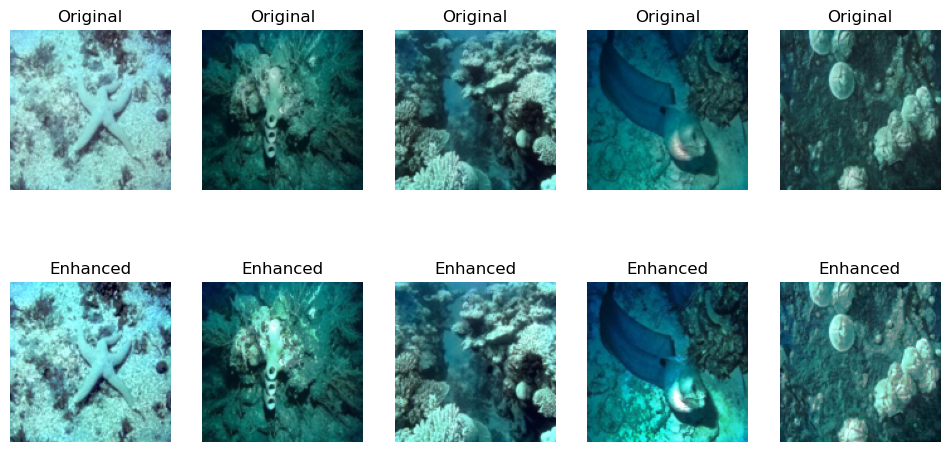

In [17]:
enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=5)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)

122.51953125
26.89453125
45.8203125
23.90625
38.84765625


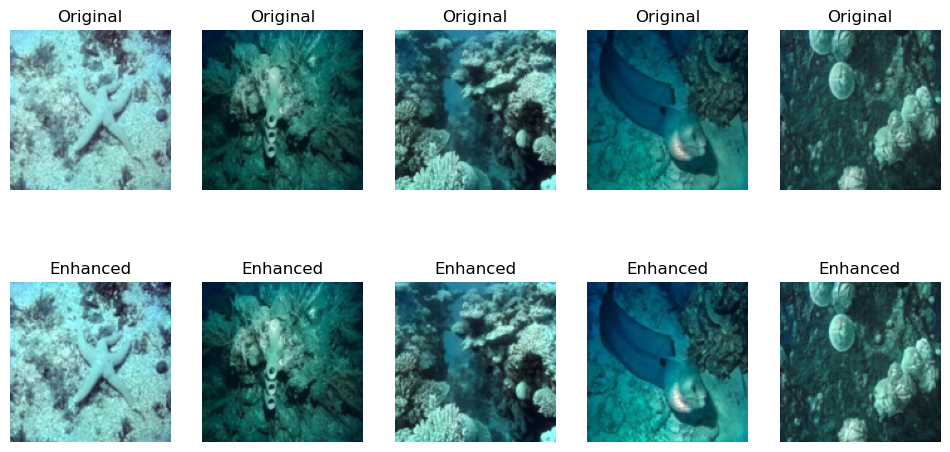

In [18]:
enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=10)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)

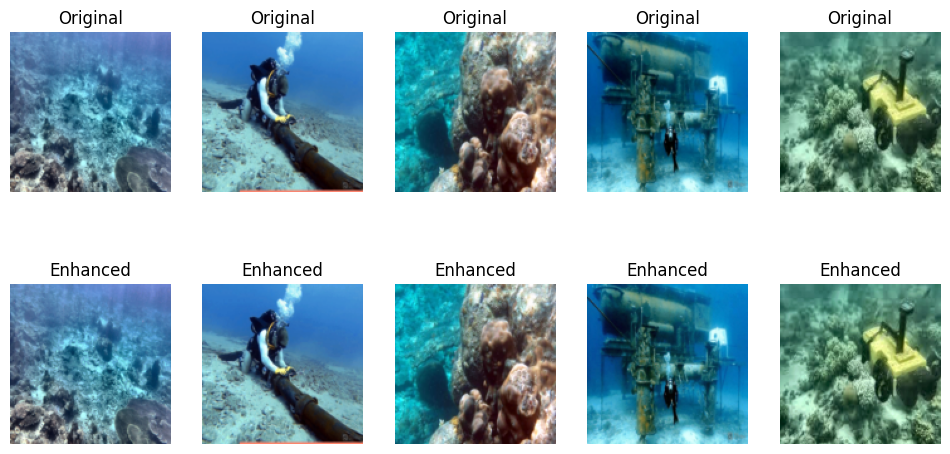

In [ ]:
data_iter = iter(dataloader)
images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=10)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

show_images(images, enhanced_images)

## Compare Results using histogram


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def display_image_and_histogram(images, enhanced_images):
    """
    Function to display an image, its histogram, enhanced image, and its histogram.

    Parameters:
        images (tensor or ndarray): Original batch of images (batch_size, 3, height, width).
        enhanced_images (tensor or ndarray): Enhanced batch of images (batch_size, 3, height, width).
    """
    # Check if images are tensors, convert them to NumPy arrays if necessary


    if isinstance(enhanced_images, torch.Tensor):
        enhanced_images = enhanced_images.permute(0, 2, 3, 1).numpy()  # Convert (batch_size, 3, H, W) -> (batch_size, H, W, 3)
    
    batch_size = images.shape[0]

    for idx in range(batch_size):
        # Get the original image and enhanced image
        
        img = images[idx].permute(1, 2, 0).numpy()  # Convert (3, 128, 128) -> (128, 128, 3)

        img = (img * 255).astype(np.uint8)
        
        enhanced_img = enhanced_images[idx].astype(np.uint8)

        # Create a new figure for plotting
        plt.figure(figsize=(6, 6))

        # Show the original image
        plt.subplot(2, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Show the enhanced image
        plt.subplot(2, 2, 2)
        plt.imshow(enhanced_img)
        plt.title("Enhanced Image")
        plt.axis('off')

        # Compute and plot histograms for the original image
        plt.subplot(2, 2, 3)
        colors = ('r', 'g', 'b')
        for i, color in enumerate(colors):
            histogram = cv2.calcHist([img], [i], None, [256], [0, 256])
            plt.plot(histogram, color=color)
        plt.title('Original Image Histogram')
        plt.xlim([0, 256])
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        # Compute and plot histograms for the enhanced image
        plt.subplot(2, 2, 4)
        for i, color in enumerate(colors):
            histogram = cv2.calcHist([enhanced_img], [i], None, [256], [0, 256])
            plt.plot(histogram, color=color)
        plt.title('Enhanced Image Histogram')
        plt.xlim([0, 256])
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        # Display the plots
        plt.tight_layout()
        plt.show()

# Example usage:
# display_image_and_histogram(images, np.array(enhanced_images))


56.77734375
77.6953125
54.78515625
57.7734375
61.7578125


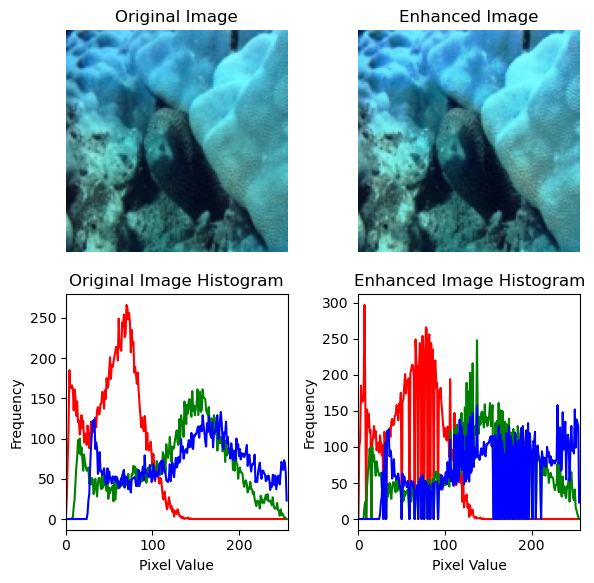

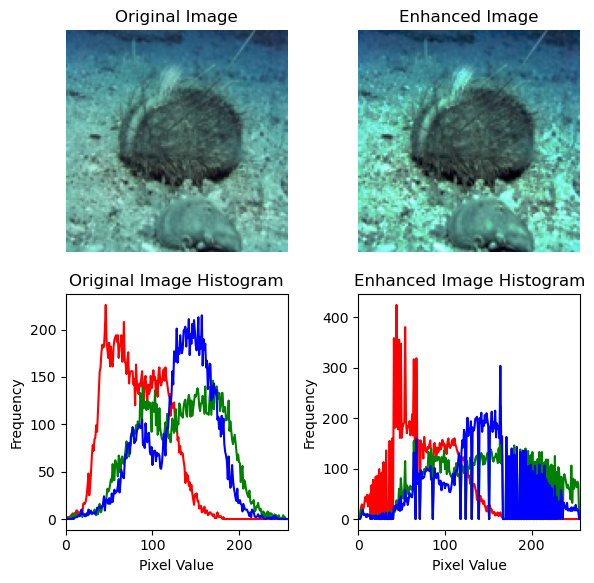

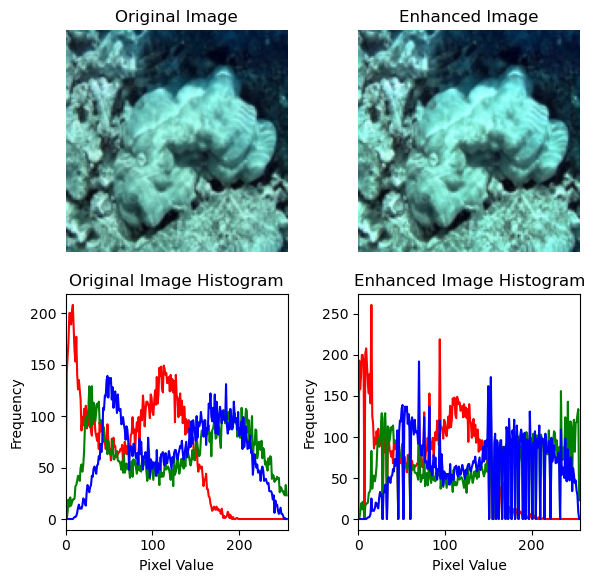

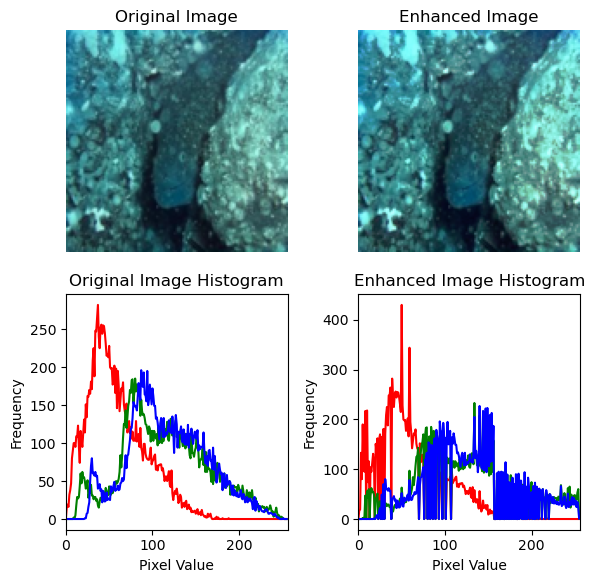

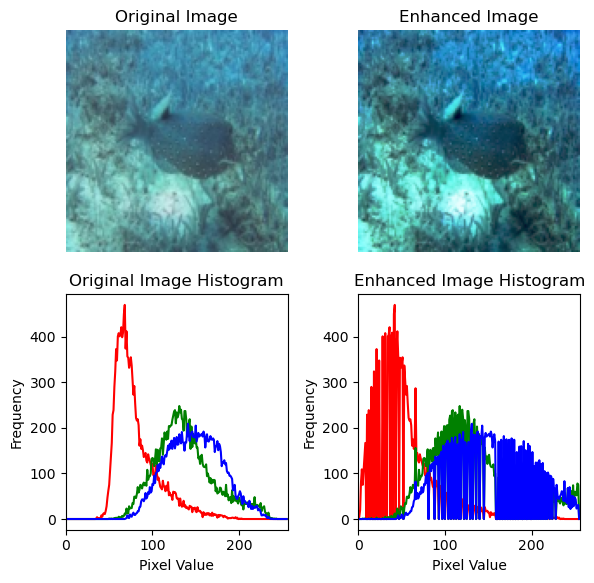

In [22]:
# data_iter = iter(dataloader)
# images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=5)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

display_image_and_histogram(images, np.array(enhanced_images))

56.77734375
77.6953125
54.78515625
57.7734375
61.7578125


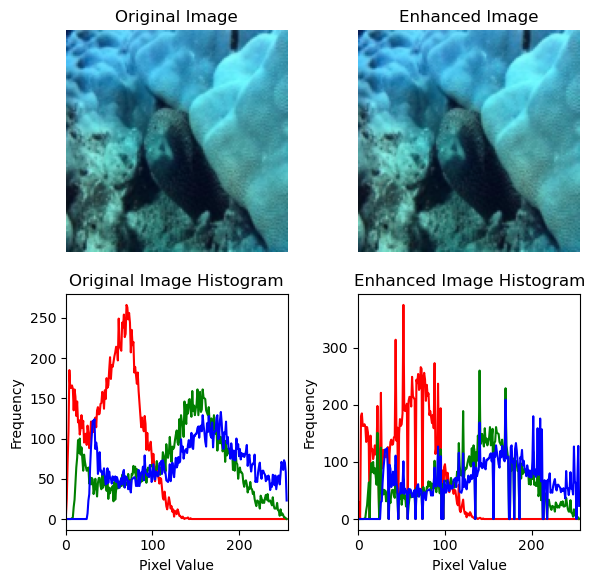

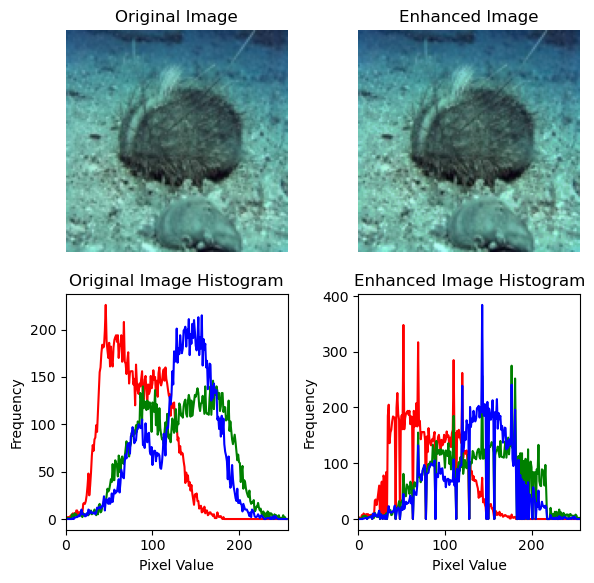

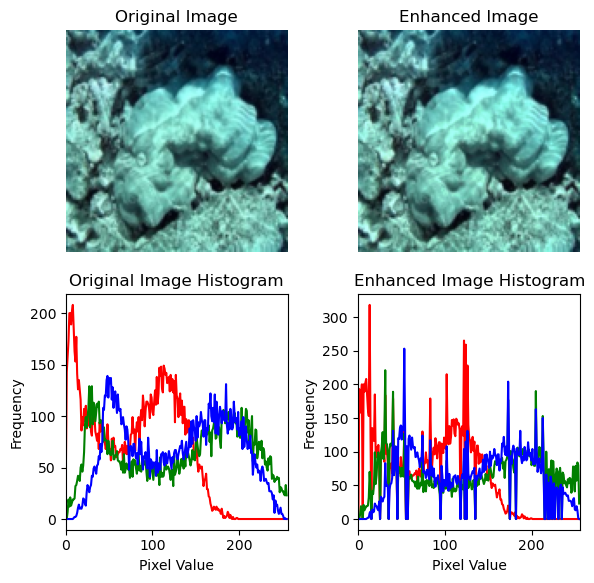

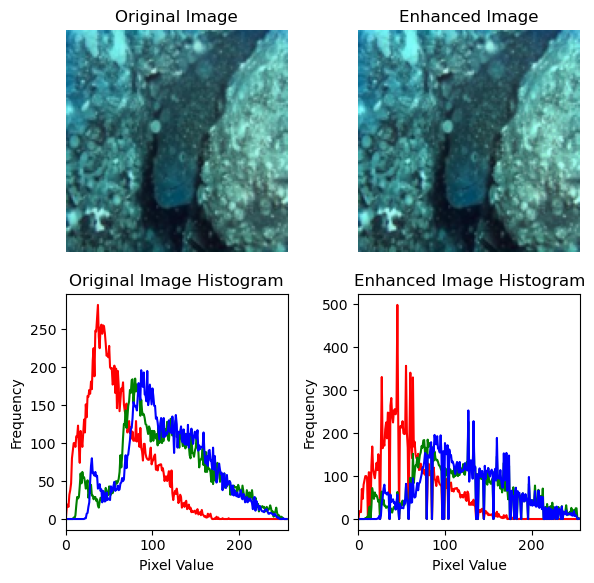

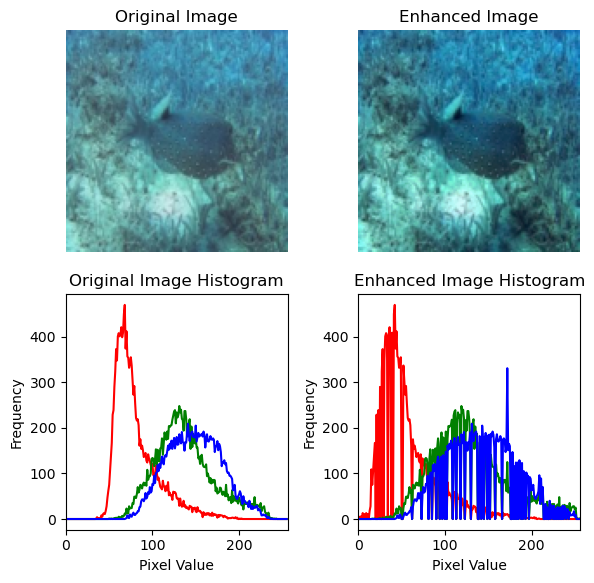

In [18]:
enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=10)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_images.append(enhanced_image)

display_image_and_histogram(images, np.array(enhanced_images))